### Still in progress!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
data_ml = pd.read_csv('data_ml.csv')

# 1 Data Inspection

In [7]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7030 non-null   int64  
 1   gender            7030 non-null   object 
 2   SeniorCitizen     7030 non-null   object 
 3   Partner           7030 non-null   object 
 4   Dependents        7030 non-null   object 
 5   tenure            7030 non-null   int64  
 6   PhoneService      7030 non-null   object 
 7   MultipleLines     7030 non-null   object 
 8   InternetService   7030 non-null   object 
 9   OnlineSecurity    7030 non-null   object 
 10  OnlineBackup      7030 non-null   object 
 11  DeviceProtection  7030 non-null   object 
 12  TechSupport       7030 non-null   object 
 13  StreamingTV       7030 non-null   object 
 14  StreamingMovies   7030 non-null   object 
 15  Contract          7030 non-null   object 
 16  PaperlessBilling  7030 non-null   object 


In [8]:
#Checking levels of categorical features
for i in data_ml.columns:
    if data_ml[i].dtype == 'object':
        print(f'{i} {data_ml[i].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


# 2 Feature Engineering

The dataset was partially processed during the exploratory data analysis (Part 1): Datatypes were changed. Redundant variables were deletet, outliers were and missing values were transformed (-> see Part 1: Exploratory Data Analysis)

## 2.1 Delete redundant variable

In [9]:
#Delete first column
data_ml = data_ml.iloc[:,1:]

## 2.2 One Hot Encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder

#Seperate data into categorical features and numerical features 
data_cat = data_ml.select_dtypes(include=['object','category']).copy()
data_num = data_ml.select_dtypes(include=['float64','int64']).copy()

ohe = OneHotEncoder()

#instantiate and fit One Hot Encoder with categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
data_cat_encoded = ohe.fit_transform(data_cat)

#Generate Dataframe with encoded categorical features
feature_names = ohe.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=feature_names, index=data_cat.index)

#Concat encoded categorical features with numerical features
data_trans = pd.concat([data_cat_df, data_num], axis=1)

## 2.3 Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

#Train/Test Split
X = data_trans.drop(columns='Churn_Yes')
y = data_trans['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

In [12]:
# Check Stratify
print('y_train',y_train.value_counts(normalize=True))
print('')
print('y_test',y_test.value_counts(normalize=True))

y_train Churn_Yes
0.0    0.735953
1.0    0.264047
Name: proportion, dtype: float64

y_test Churn_Yes
0.0    0.736131
1.0    0.263869
Name: proportion, dtype: float64


## 2.4 Quantile Transforming

Quantile transformation of the features 'MonthlyCharges' and 'Total Charges' and 'tenure
.fit_transform of X_train and .transform of X_test to avoid data leakage

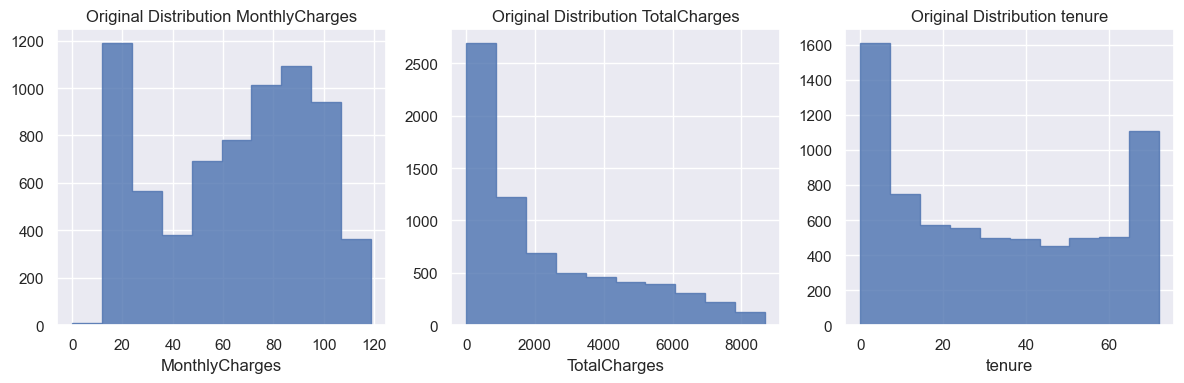

In [13]:
#Plot original distribution of Monthly and Total Charges

def dist_before_quantile():

    fig, ax = plt.subplots(1,3,figsize=(12,4))

    #Subplot 1: Monthlycharges
    data_ml.MonthlyCharges.hist(ax=ax[0],histtype='step',fill=True,alpha=0.8)
    ax[0].set_title('Original Distribution MonthlyCharges')
    ax[0].set_xlabel('MonthlyCharges')
    ax[0].set_ylabel=('Count')

    #Subplot 2: Totalcharges
    data_ml.TotalCharges.hist(ax=ax[1],histtype='step',fill=True,alpha=0.8)
    ax[1].set_title('Original Distribution TotalCharges')
    ax[1].set_xlabel('TotalCharges')
    ax[1].set_ylabel=('Count')

    #Subplot 3: tenure
    data_ml.tenure.hist(ax=ax[2],histtype='step',fill=True,alpha=0.8)
    ax[2].set_title('Original Distribution tenure')
    ax[2].set_xlabel('tenure')
    ax[2].set_ylabel=('Count')

    plt.tight_layout()

dist_before_quantile()

In [14]:
#Quantile Transforming

from sklearn.preprocessing import QuantileTransformer

#Instantiate Quantile Transformer
quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges','TotalCharges','tenure']] = quantile_normal.fit_transform(X_train[['MonthlyCharges','TotalCharges','tenure']])

#Transform X_test
X_test[['MonthlyCharges','TotalCharges','tenure']] = quantile_normal.transform(X_test[['MonthlyCharges','TotalCharges','tenure']])

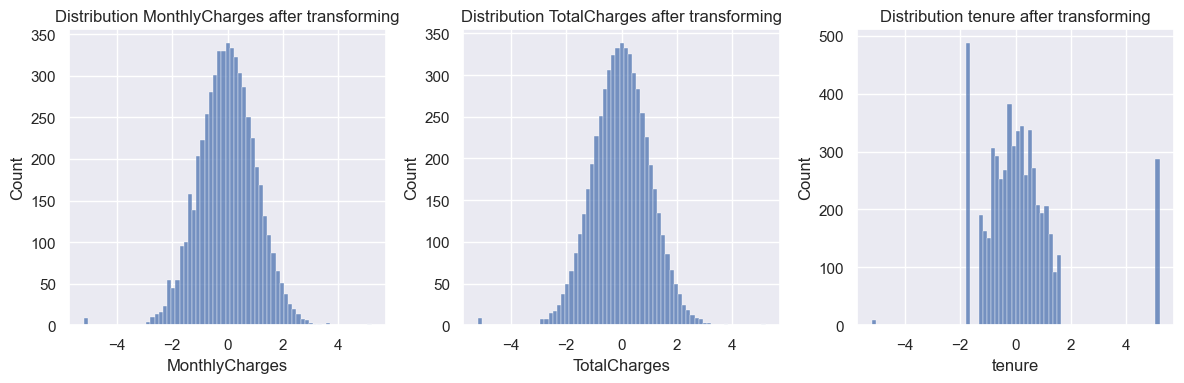

In [15]:
#Plot distribution after transforming

def dist_after_quantile():
    fig, ax = plt.subplots(1,3,figsize=(12,4))

    #Subplot 1: transformed MonthlyCharges
    sns.histplot(X_train.MonthlyCharges,ax=ax[0])
    ax[0].set_title('Distribution MonthlyCharges after transforming')
    ax[0].set_xlabel('MonthlyCharges')
    ax[0].set_ylabel=('Count')

    #Subplot 2: transformed TotalCharges
    sns.histplot(X_train.TotalCharges,ax=ax[1])
    ax[1].set_title('Distribution TotalCharges after transforming')
    ax[1].set_xlabel('TotalCharges')
    ax[1].set_ylabel=('Count')

    #Subplot 3: transformed tenure
    sns.histplot(X_train.tenure,ax=ax[2])
    ax[2].set_title('Distribution tenure after transforming')
    ax[2].set_xlabel('tenure')
    ax[2].set_ylabel=('Count')

    plt.tight_layout()

dist_after_quantile()

## 2.5 Class Balancing

In [16]:
#Original Distribution target 'Churn'
data_ml.Churn.value_counts(normalize=True)

Churn
No     0.735989
Yes    0.264011
Name: proportion, dtype: float64

In [17]:
#Oversampling/Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)
X_train_bal, y_train_bal = pipeline.fit_resample(X_train,y_train)


#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [18]:
y_train_bal.value_counts()

Churn_Yes
0.0    4139
1.0    4139
Name: count, dtype: int64

# 3 Training

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import ValidationCurveDisplay

import mlflow
from mlflow.models.signature import infer_signature
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')

## 3.1 Metric

Goal is to keep as much as customers as possible. Therefore, recall is the best metric for this. It answers the question, how good the model is in predicting customers which are truly churned.

Recall (True Positive Rate) = True Positives / True Positives + False Negative

## 3.2 Model 1: Logistic Regression

In [ ]:
#Instantiate LogisticRegression
lr = LogisticRegression(solver='saga',max_iter=1000)

#Dictionary for hyperparameter tuning
lr_param_dict = {'penalty':['l1','l2'],
                 'C':[0.001, 0.01, 0.1]}

#Instantiate GridsearchCV
gridcv_lr = GridSearchCV(estimator=lr,cv=5,param_grid=lr_param_dict,scoring='recall')

#Fit Gridsearch with balanced Classes
model_lr = gridcv_lr.fit(X_train_bal,y_train_bal)

#Best params
best_params_lr = model_lr.best_params_

#Best score
best_score_lr = model_lr.best_score_

#Mean test score
mean_test_score_lr = model_lr.cv_results_['mean_test_score']


print(f'best params: {best_params_lr}')
print(f'best recall: {best_score_lr} \n')
print(f'mean_test_score: {mean_test_score_lr} \n')


####################################################################################

#Set new experiment

def mlflow_tracking():
    mlflow.set_experiment('Churn Prediction Telco')

    #start MlFlow run
    with mlflow.start_run():
        mlflow.log_param("lr_params", lr_param_dict)
        mlflow.log_metric('recall', best_score_lr)  
        mlflow.set_tag("Training Info", "GridSearchCV Log Regression")

        best_model_lr = model_lr.best_estimator_

        # Infer signature
        signature = infer_signature(X_train_bal, best_model_lr.predict(X_train_bal))

        # Log Model
        model_info = mlflow.sklearn.log_model(
            sk_model=best_model_lr,
            artifact_path="Log Regression",
            signature=signature,
            input_example=X_train_bal,
            registered_model_name="Log Regression",
        )

#Execute function
mlflow_tracking()

best params: {'C': 0.1, 'penalty': 'l1'}
best recall: 0.8175893310901985 

[0.71659511 0.81662198 0.81493291 0.81058246 0.81758933 0.81396556]


## 3.3 Model 2: K Nearest Neighbors

In [1]:
'''
ValidationCurveDisplay.from_estimator(
   KNeighborsClassifier(), X_train_bal, y_train_bal,
       param_name="n_neighbors", param_range=[20,30,40,50,60,70,80,90,100],scoring='recall')'
'''

'\nValidationCurveDisplay.from_estimator(\n   KNeighborsClassifier(), X_train_bal, y_train_bal,\n       param_name="n_neighbors", param_range=[20,30,40,50,60,70,80,90,100],scoring=\'recall\')\'\n'

In [ ]:
#Instantiate KNN
knn = KNeighborsClassifier()

#Dictionary for hyperparameter tuning
neighbors_range = range(60,100)
#knn_param_dict = {'n_neighbors':neighbors_range}

knn_param_dict = {
    'n_neighbors': neighbors_range,
    #'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan','hamming'],  
    #'leaf_size': [10, 20, 30],
}

#Instantiate GridsearchCV
gridcv_knn = GridSearchCV(estimator=knn,cv=5,param_grid=knn_param_dict,scoring='recall')  #return_train_score=True

#Fit Gridsearch with training data
model_knn = gridcv_knn.fit(X_train_bal,y_train_bal)

#Best params
best_params_knn = model_knn.best_params_

#Best score
best_score_knn = model_knn.best_score_

#Mean test score
mean_test_score_knn = model_knn.cv_results_['mean_test_score']


print(f'best params: {best_params_knn}')
print(f'best recall: {best_score_knn} \n')
print(f'mean_test_score: {mean_test_score_knn} \n')


####################################################################################

#Set new experiment

def mlflow_tracking():
    mlflow.set_experiment('Churn Prediction Telco')

    #start MlFlow run
    with mlflow.start_run():
        mlflow.log_param("knn_params", knn_param_dict)
        mlflow.log_metric('recall', best_score_knn)  
        mlflow.set_tag("Training Info", "GridSearchCV KNN")

        best_model_knn = model_knn.best_estimator_

        # Infer signature
        signature = infer_signature(X_train_bal, best_model_knn.predict(X_train_bal))

        # Log Model
        model_info = mlflow.sklearn.log_model(
            sk_model=best_model_knn,
            artifact_path="KNN",
            signature=signature,
            input_example=X_train_bal,
            registered_model_name="KNN",
        )

#Execute function
mlflow_tracking()

best params: {'metric': 'euclidean', 'n_neighbors': 99}
best recall: 0.8994917897762124 

mean_test_score: [0.8917632  0.89611132 0.89248696 0.89731963 0.89297034 0.89731875
 0.89369469 0.89828552 0.8944202  0.89780184 0.89393653 0.89611044
 0.89297005 0.89731934 0.89272821 0.89611015 0.89296976 0.8958686
 0.89417749 0.89707691 0.89514426 0.8975603  0.89562735 0.89876774
 0.89538551 0.8975603  0.89562706 0.89755971 0.89562647 0.89755942
 0.89635169 0.89804281 0.89659295 0.89828435 0.89514367 0.89852561
 0.89635111 0.89876715 0.89659295 0.89949179 0.86180391 0.8678449
 0.86252943 0.86905292 0.86204663 0.86712114 0.86252972 0.86784548
 0.86422083 0.86881108 0.86446179 0.86905233 0.86518731 0.86929446
 0.86591224 0.87026123 0.86639504 0.86905292 0.86663688 0.87098499
 0.86663688 0.8700191  0.86760306 0.87026065 0.86663658 0.87122654
 0.8683277  0.87219301 0.86832799 0.87364258 0.87098529 0.87388442
 0.87074403 0.87412597 0.87098558 0.8748506  0.87098587 0.8748509
 0.87146867 0.87509273 0.

## 3.4 Model 3: Support Vector Machines

In [ ]:
#Instantiate Support Vector Classifier
svm = SVC(probability=True)

#Dictionary for hyperparameter tuning
svm_param_dict = {
    'C': [0.01,0.1], #0.001 removed
    'kernel': ['linear','rbf'], #poly removed to save runtime
    'gamma': ['scale', 'auto']} #0.1 and 0.001 removed

#Instantiate GridsearchCV
gridcv_svm = GridSearchCV(estimator=svm,cv=5,param_grid=svm_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_svm = gridcv_svm.fit(X_train_bal,y_train_bal)

# Best params
best_params_svm = model_svm.best_params_

#Best score
best_score_svm = model_svm.best_score_

#Mean test score
mean_test_score_svm = model_svm.cv_results_['mean_test_score']


print(f'best params: {best_params_svm}')
print(f'best recall: {best_score_svm} \n')
print(f'mean_test_score: {mean_test_score_svm} \n')


#############################################################################

#Set new experiment

def mlflow_tracking():
    mlflow.set_experiment('Churn Prediction Telco')

    #start MlFlow run
    with mlflow.start_run():
        mlflow.log_param("svm_params", svm_param_dict)
        mlflow.log_metric('recall', best_score_svm)  
        mlflow.set_tag("Training Info", "GridSearchCV SVM")

        best_model_svm = model_svm.best_estimator_

        # Infer signature
        signature = infer_signature(X_train_bal, best_model_svm.predict(X_train_bal))

        # Log Model
        model_info = mlflow.sklearn.log_model(
            sk_model=best_model_svm,
            artifact_path="SVM",
            signature=signature,
            input_example=X_train_bal,
            registered_model_name="SVM",
        )

#Execute function
mlflow_tracking()

best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
best recall: 0.8277351348509543 

[0.82000245 0.79729334 0.82000245 0.80550736 0.82773513 0.80937151
 0.82773513 0.81058012]


## 3.5 Model 4: Random Forest

In [ ]:
#Instantiate Random Forest
rf = RandomForestClassifier(n_jobs=-1,random_state=123)

#Dictionary for hyperparameter tuning
rf_param_dict = {
    'max_depth': [10,20],
    'min_samples_leaf':[15,30],  #15,30
    'max_features': [2,3,4,5] #mtry #sqrt
}

#Instantiate GridsearchCV
gridcv_rf = GridSearchCV(estimator=rf,cv=5,param_grid=rf_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_rf = gridcv_rf.fit(X_train_bal,y_train_bal)

#Best params
best_params_rf = model_rf.best_params_

#Best score
best_score_rf = model_rf.best_score_

#Mean test score
mean_test_score_rf = model_rf.cv_results_['mean_test_score']


print(f'best params: {best_params_rf}')
print(f'best recall: {best_score_rf} \n')
print(f'mean_test_score: {mean_test_score_rf} \n')


###################################################################################

#MLFlow experiment tracking

def mflow_tracking():

    #Set new experiment
    mlflow.set_experiment('Churn Prediction Telco')

    #start MlFlow run
    with mlflow.start_run():
        mlflow.log_param("rf_params", best_params_rf)
        mlflow.log_metric('recall', best_score_rf)  
        mlflow.set_tag("Training Info", "GridSearchCV Random Forest")

        best_model_rf = model_rf.best_estimator_

        # Infer signature
        signature = infer_signature(X_train_bal, best_model_rf.predict(X_train_bal))

        # Log Model
        model_info = mlflow.sklearn.log_model(
            sk_model=best_model_rf,
            artifact_path="Random Forest",
            signature=signature,
            input_example=X_train_bal,
            registered_model_name="Random Forest"
        )

#Execute function
mflow_tracking()

2025/03/27 11:17:42 INFO mlflow.tracking.fluent: Experiment with name 'Churn Prediction Telco' does not exist. Creating a new experiment.


best params: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 15}
best recall: 0.8318443357926035 

mean_test_score: [0.83184434 0.82628936 0.8262879  0.8185561  0.82459445 0.81710536
 0.82918558 0.81758933 0.82773806 0.82822261 0.82411341 0.81831543
 0.82338877 0.8134813  0.82459562 0.81589851] 



Registered model 'Random Forest' already exists. Creating a new version of this model...
2025/03/27 11:17:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest, version 5


🏃 View run thoughtful-goose-406 at: http://127.0.0.1:8080/#/experiments/771685581311785134/runs/c050a73662e4412dac326ecc928c1984
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/771685581311785134


Created version '5' of model 'Random Forest'.


# 4 Best Model

## 4.1 Testing

In [ ]:
#Test best model
y_pred_best_model = model_knn.predict(X_test)

recall: 0.8733153638814016

accuracy_score: 0.7034139402560455
precision_score: 0.4668587896253602
f1_score: 0.6084507042253521
roc_auc_score: 0.7579137205880438


## 4.2 Evaluation

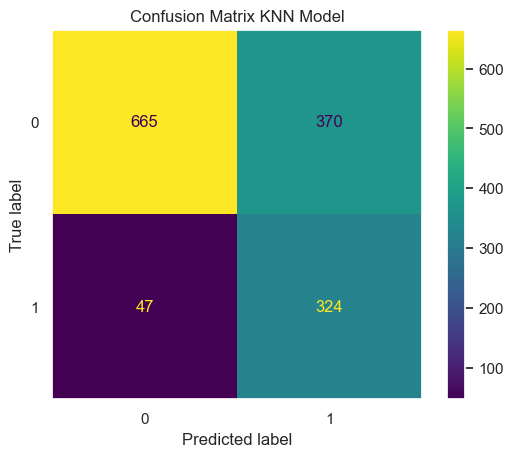

In [38]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix KNN Model')
plt.grid()

In [ ]:
#Evaluation
print('recall:',recall_score(y_test,y_pred_best_model))
print('')
print('accuracy_score:' ,accuracy_score(y_test,y_pred_best_model))
print('precision_score:', precision_score(y_test,y_pred_best_model))
print('f1_score:', f1_score(y_test,y_pred_best_model))
print('roc_auc_score:', roc_auc_score(y_test,y_pred_best_model))

NameError: name 'data_ml' is not defined